<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/ML_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Lab 2** 2311201205


---



**Write a program to construct a Decision Tree for any four datasets downloaded from the KEEL dataset repository using the following algorithms:**

a) ID3  
b) C4.5  
c) CART  

Evaluate the performance using the following metrics:

a) Confusion Matrix  
b) Precision and Recall for each class  
c) Area Under the Curve (AUC), assuming Setosa as the positive class  
d) Geometric Mean  

Explain the following terms:

- True Positive Rate (TPR)  
- Area Under the Curve (AUC)  
- F-Measure  


We define the 4 datasets that we would work on -

In [13]:
DATASETS = ["iris","glass","haberman","wine"]

In [14]:
import os, tempfile
import pandas as pd
import numpy as np
import scipy.io.arff as arff
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, balanced_accuracy_score
)

In [15]:
def load_keel(folder, names):
    out = {}
    for f in os.listdir(folder):
        if f.endswith(".dat") and any(f.startswith(n) for n in names):
            lines = open(folder+f).readlines()
            lines = [l for l in lines if not l.lower().startswith(("@inputs","@output"))]

            tmp = tempfile.NamedTemporaryFile(delete=False, mode="w")
            tmp.writelines(lines); tmp.close()

            d,_ = arff.loadarff(tmp.name)
            df = pd.DataFrame(d)
            df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)

            out[f] = df
    return out


In [16]:
datasets = load_keel("/content/",DATASETS)

print(datasets.keys())


dict_keys(['wine-5-5tst.dat', 'glass-5-4tst.dat', 'glass-5-3tra.dat', 'haberman-5-3tst.dat', 'wine-5-3tst.dat', 'iris-5-3tst.dat', 'iris-5-5tst.dat', 'glass-5-2tra.dat', 'glass-5-1tra.dat', 'haberman-5-4tra.dat', 'iris-5-3tra.dat', 'iris-5-4tst.dat', 'wine-5-5tra.dat', 'glass-5-2tst.dat', 'glass-5-5tra.dat', 'wine-5-2tra.dat', 'haberman-5-5tst.dat', 'iris-5-5tra.dat', 'glass-5-5tst.dat', 'iris-5-2tra.dat', 'glass-5-1tst.dat', 'wine-5-1tra.dat', 'haberman-5-2tst.dat', 'haberman-5-3tra.dat', 'glass-5-4tra.dat', 'haberman-5-4tst.dat', 'iris-5-2tst.dat', 'glass-5-3tst.dat', 'wine-5-4tra.dat', 'wine-5-4tst.dat', 'haberman-5-2tra.dat', 'iris-5-4tra.dat', 'haberman-5-5tra.dat', 'haberman-5-1tra.dat', 'iris-5-1tra.dat', 'haberman-5-1tst.dat', 'wine-5-1tst.dat', 'iris-5-1tst.dat', 'wine-5-2tst.dat', 'wine-5-3tra.dat'])


In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay,
    balanced_accuracy_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

def evaluate_dataset(datasets, name):
    acc, bal_acc, aucs = [], [], []

    for i in range(1, 6):
        train = datasets[f"{name}-5-{i}tra.dat"]
        test  = datasets[f"{name}-5-{i}tst.dat"]

        Xtr, ytr = train.iloc[:, :-1], train.iloc[:, -1]
        Xte, yte = test.iloc[:, :-1], test.iloc[:, -1]

        clf = DecisionTreeClassifier(criterion="gini", random_state=0)
        clf.fit(Xtr, ytr)

        ypred = clf.predict(Xte)
        yprob = clf.predict_proba(Xte)

        acc.append(accuracy_score(yte, ypred))
        bal_acc.append(balanced_accuracy_score(yte, ypred))

        pos = clf.classes_[0]
        y_true_bin = (yte == pos).astype(int)
        y_score = yprob[:, list(clf.classes_).index(pos)]
        aucs.append(roc_auc_score(y_true_bin, y_score))

        # ---- Representative outputs (Fold 1 only) ----
        if i == 1:
            rep_clf, rep_Xte, rep_yte = clf, Xte, yte
            rep_ytrue_bin, rep_yscore = y_true_bin, y_score

    # -------- CLEAN REPORT --------
    print("\n" + "="*55)
    print(f"DATASET : {name.upper()}")
    print("ALGORITHM : CART (Gini Index)")
    print("="*55)

    print("Final Accuracy (mean of 5 folds):",
          round(np.mean(acc), 4))
    print("Balanced Accuracy:",
          round(np.mean(bal_acc), 4))
    print("AUC (One-vs-Rest):",
          round(np.mean(aucs), 4))

    print("\nClassification Report (Representative Fold):")
    print(classification_report(rep_yte, rep_clf.predict(rep_Xte)))

    # ---- Visual Outputs ----
    ConfusionMatrixDisplay.from_estimator(rep_clf, rep_Xte, rep_yte)
    plt.title("Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_predictions(
        rep_ytrue_bin,
        rep_yscore,
        name=f"{name} (Positive = {rep_clf.classes_[0]})"
    )
    plt.title("ROC Curve")
    plt.show()

    plt.figure(figsize=(14,6))
    plot_tree(
        rep_clf,
        feature_names=Xtr.columns,
        class_names=rep_clf.classes_,
        filled=True
    )
    plt.title("CART Decision Tree")
    plt.show()



DATASET : IRIS
ALGORITHM : CART (Gini Index)
Final Accuracy (mean of 5 folds): 0.94
Balanced Accuracy: 0.94
AUC (One-vs-Rest): 1.0

Classification Report (Representative Fold):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



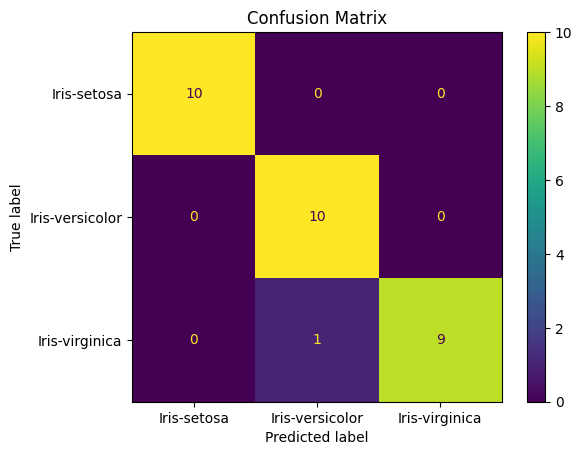

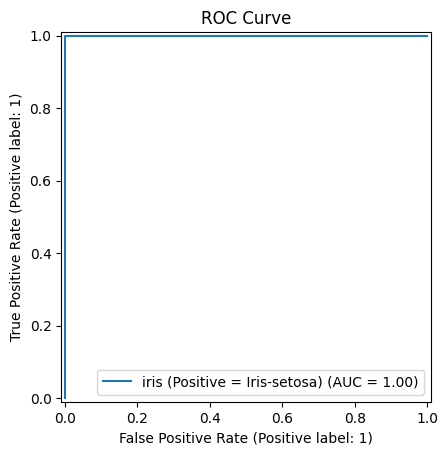

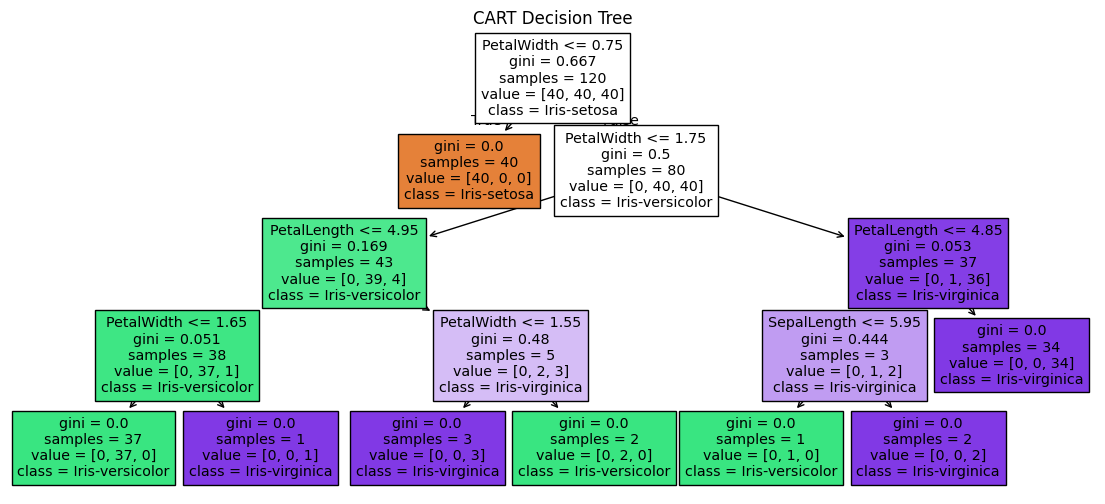


DATASET : GLASS
ALGORITHM : CART (Gini Index)
Final Accuracy (mean of 5 folds): 0.6872
Balanced Accuracy: 0.6411
AUC (One-vs-Rest): 0.773

Classification Report (Representative Fold):
              precision    recall  f1-score   support

           1       0.62      0.71      0.67        14
           2       0.67      0.62      0.65        16
           3       0.25      0.33      0.29         3
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         1
           7       1.00      0.83      0.91         6

    accuracy                           0.63        43
   macro avg       0.51      0.47      0.48        43
weighted avg       0.64      0.63      0.63        43



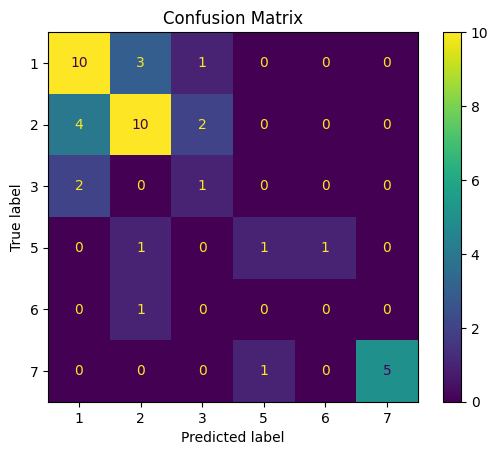

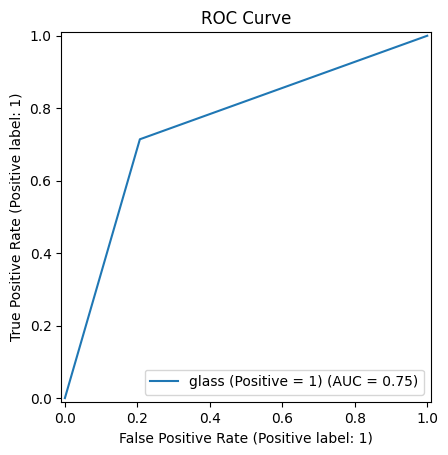

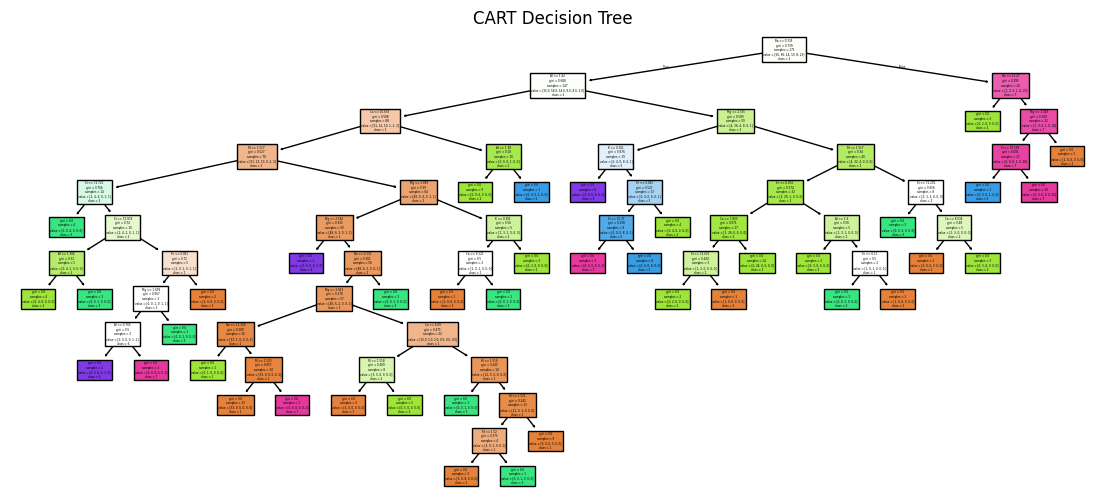


DATASET : HABERMAN
ALGORITHM : CART (Gini Index)
Final Accuracy (mean of 5 folds): 0.6536
Balanced Accuracy: 0.5554
AUC (One-vs-Rest): 0.5524

Classification Report (Representative Fold):
              precision    recall  f1-score   support

    negative       0.74      0.78      0.76        45
    positive       0.33      0.29      0.31        17

    accuracy                           0.65        62
   macro avg       0.54      0.54      0.54        62
weighted avg       0.63      0.65      0.64        62



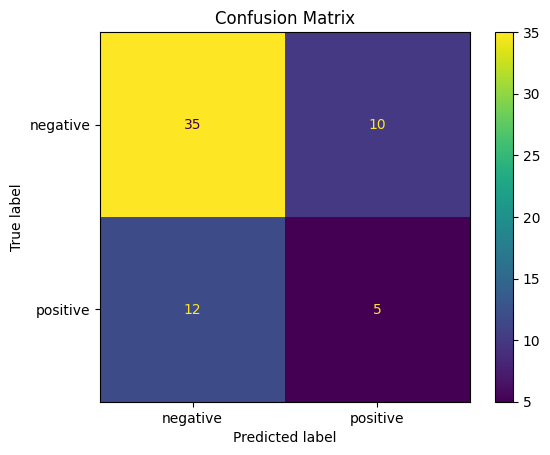

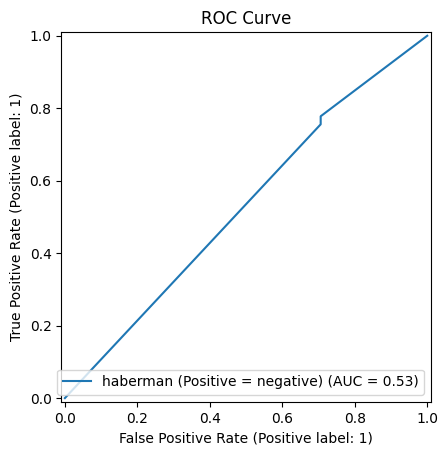

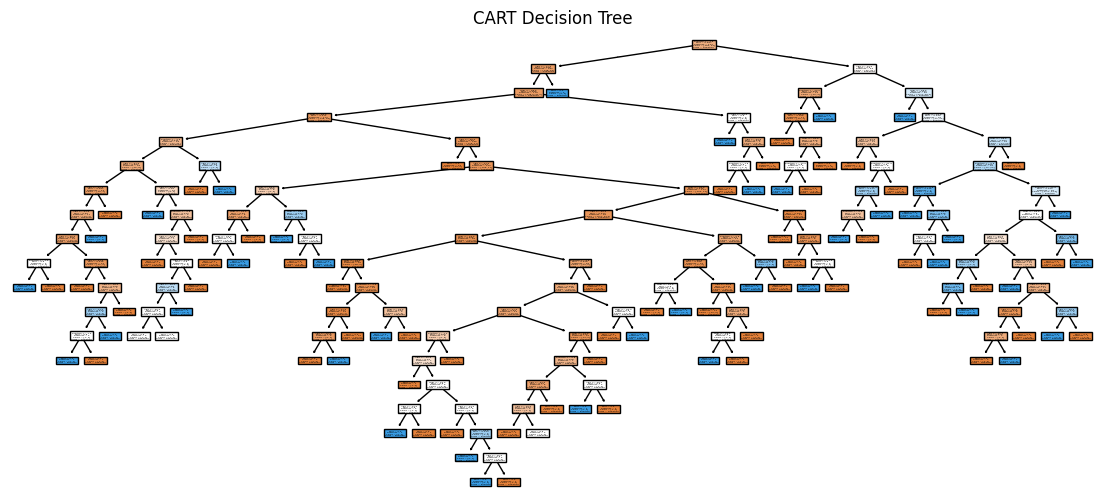


DATASET : WINE
ALGORITHM : CART (Gini Index)
Final Accuracy (mean of 5 folds): 0.9156
Balanced Accuracy: 0.9175
AUC (One-vs-Rest): 0.9366

Classification Report (Representative Fold):
              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



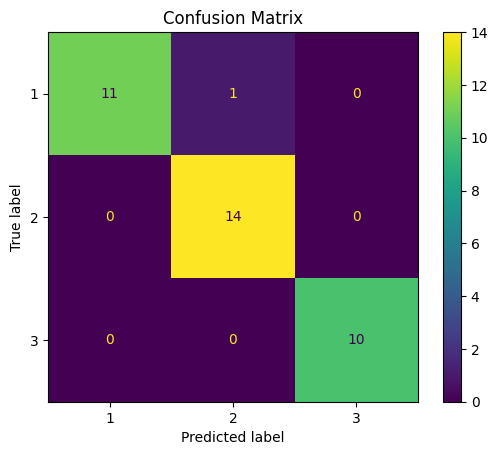

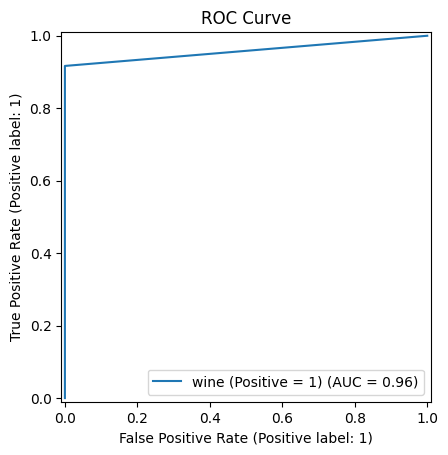

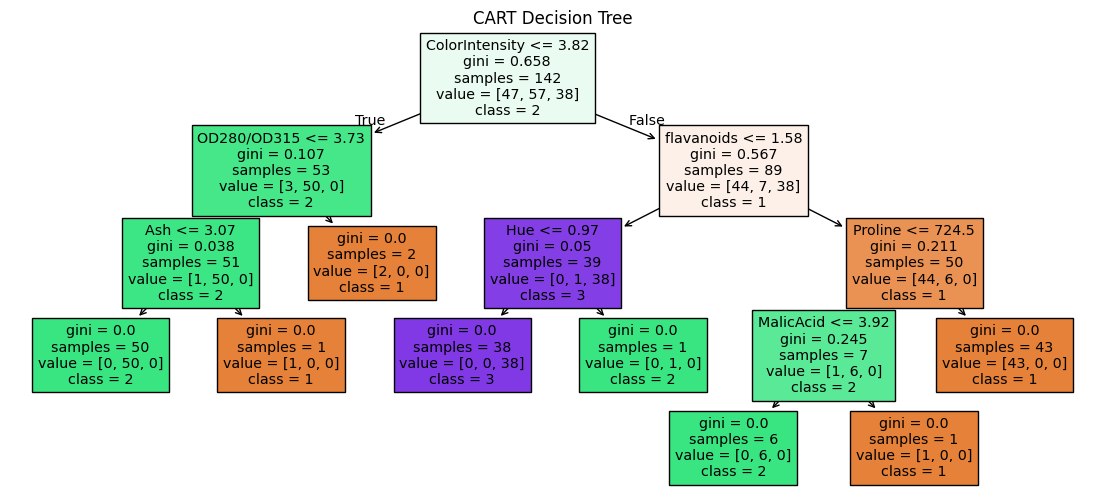

In [18]:
for d in DATASETS:
    evaluate_dataset(datasets, d)